<a href="https://colab.research.google.com/github/amartsin/Exudate-Segmentation/blob/main/EXUDATE_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from numba import jit
import os
from matplotlib import pyplot as plt
import math
import csv
from sklearn import preprocessing

In [ ]:
@jit
def standard_deviation_image(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	clahe_output = clahe.apply(image)
	result = clahe_output.copy()
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			sub_image = clahe_output[i:i+20,j:j+25]
			var = np.var(sub_image)
			result[i:i+20,j:j+25] = var
			j = j+25
		i = i+20
	return result

In [ ]:
@jit
def deviation_from_mean(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	clahe_output = clahe.apply(image)
	print(clahe_output)
	result = clahe_output.copy()
	result = result.astype('int')
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			sub_image = clahe_output[i:i+5,j:j+5]
			mean = np.mean(sub_image)
			sub_image = sub_image - mean
			result[i:i+5,j:j+5] = sub_image
			j = j+5
		i = i+5
	return result

In [ ]:
def get_DistanceFromOD_data(image, centre):
	my_image = image.copy()
	x_cor = centre[0]
	y_cor = centre[1]
	feature_5 = np.reshape(image, (image.size,1))
	k = 0
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			feature_5[k] = math.fabs(x_cor-i) + math.fabs(y_cor-j)
			j = j+1
			k = k+1
		i = i+1
	return feature_5


In [ ]:
@jit
def remove_bv_image(image,bv_image):
	edge_result = image[:,:]				
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			if edge_result[i,j] == 255 and bv_image[i,j] == 255:
				edge_result[i,j] = 0
			j = j+1
		i = i+1
	return edge_result

In [ ]:
def get_average_intensity(green_channel):
	average_intensity = green_channel.copy()
	i = 0
	j = 0
	while i < green_channel.shape[0]:
		j = 0
		while j < green_channel.shape[1]:
			sub_image = green_channel[i:i+20,j:j+25]
			mean = np.mean(sub_image)
			average_intensity[i:i+20,j:j+25] = mean
			j = j+25
		i = i+20
	result = np.reshape(average_intensity, (average_intensity.size,1))
	return result

In [ ]:
def get_average_hue(hue_image):
	average_hue = hue_image.copy()
	i = 0
	j = 0
	while i < hue_image.shape[0]:
		j = 0
		while j < hue_image.shape[1]:
			sub_image = hue_image[i:i+20,j:j+25]
			mean = np.mean(sub_image)
			average_hue[i:i+20,j:j+25] = mean
			j = j+25
		i = i+20
	result = np.reshape(average_hue, (average_hue.size,1))
	return result


In [ ]:
def get_average_saturation(hue_image):
	average_hue = hue_image.copy()
	i = 0
	j = 0
	while i < hue_image.shape[0]:
		j = 0
		while j < hue_image.shape[1]:
			sub_image = hue_image[i:i+20,j:j+25]
			mean = np.mean(sub_image)
			average_hue[i:i+20,j:j+25] = mean
			j = j+25
		i = i+20
	result = np.reshape(average_hue, (average_hue.size,1))
	return result

In [ ]:
def get_SD_data(sd_image):	
	feature_1 = np.reshape(sd_image, (sd_image.size,1))
	return feature_1

def get_HUE_data(hue_image):	
	feature_2 = np.reshape(hue_image,(hue_image.size,1))	
	return feature_2

def get_saturation_data(s_image):
	feature = np.reshape(s_image,(s.size,1))	
	return feature


def get_INTENSITY_data(intensity_image):	
	feature_3 = np.reshape(intensity_image,(intensity_image.size,1))	
	return feature_3

def get_EDGE_data(edge_candidates_image):
	feature_4 = np.reshape(edge_candidates_image,(edge_candidates_image.size,1))	
	return feature_4

In [ ]:

def get_RED_data(red_channel):	
	feature_5 = np.reshape(red_channel, (red_channel.size,1))	
	return feature_5

def get_GREEN_data(green_channel):
	feature_6 = np.reshape(green_channel, (green_channel.size,1))	
	return feature_6


def line_of_symmetry(image):
	image_v = image.copy()
	line = 0
	prev_diff = image_v.size
	for i in range(20,image_v.shape[0]-20):
		x1, y1 = image_v[0:i,:].nonzero()
		x2, y2 = image_v[i+1:image_v.shape[0],:].nonzero()
		diff = abs(x1.shape[0] - x2.shape[0])
		if diff < prev_diff:
			prev_diff = diff
			line = i
		i = i + 35
	return line

In [ ]:
def identify_OD(image):
	newfin = cv2.dilate(image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations=2)
	mask = np.ones(newfin.shape[:2], dtype="uint8") * 255
	ycontours, yhierarchy = cv2.findContours(newfin.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
	prev_contour = ycontours[0]
	for cnt in ycontours:
		if cv2.contourArea(cnt) >= cv2.contourArea(prev_contour):
			prev_contour = cnt
			cv2.drawContours(mask, [cnt], -1, 0, -1)
	M = cv2.moments(prev_contour)
	cx = int(M['m10']/M['m00'])
	cy = int(M['m01']/M['m00'])	
	return (cx,cy)


In [ ]:
def identify_OD_bv_density(blood_vessel_image):
	los = line_of_symmetry(blood_vessel_image)
	sub_image = blood_vessel_image[los-100:los+100,:]
	i = 0
	index = 0
	density = -1
	rr = 0	
	while i < sub_image.shape[1]:
		x1,y1 = sub_image[:,i:i+50].nonzero()
		count = x1.shape[0]		
		if(density < count):
			density = count
			index = i
		i = i + 30	
	#print(los,index)
	return (index,los)

In [ ]:
@jit
def edge_pixel_image(image,bv_image):
	edge_result = image.copy()
	edge_result = cv2.Canny(edge_result,30,100)	
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			if edge_result[i,j] == 255 and bv_image[i,j] == 255:
				edge_result[i,j] = 0
			j = j+1
		i = i+1
	newfin = cv2.dilate(edge_result, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
	return newfin

In [ ]:
def extract_bv(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	contrast_enhanced_green_fundus = clahe.apply(image)
	# applying alternate sequential filtering (5 times closing opening)
	r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	r4 = cv2.morphologyEx(R3, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(47,47)), iterations = 1)
	R4 = cv2.morphologyEx(r4, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(47,47)), iterations = 1)
	r5 = cv2.morphologyEx(R4, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(95,95)), iterations = 1)
	R5 = cv2.morphologyEx(r5, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(95,95)), iterations = 1)
	
	f4 = cv2.subtract(R4,contrast_enhanced_green_fundus)
	f5 = clahe.apply(f4)

	# removing very small contours through area parameter noise removal
	ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
	mask = np.ones(f5.shape[:2], dtype="uint8") * 255
	contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
	for cnt in contours:
		if cv2.contourArea(cnt) <= 200:
			cv2.drawContours(mask, [cnt], -1, 0, -1)			
	im = cv2.bitwise_and(f5, f5, mask=mask)
	ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
	newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

	# removing blobs of microaneurysm & unwanted bigger chunks taking in consideration they are not straight lines like blood
	# vessels and also in an interval of area
	fundus_eroded = cv2.bitwise_not(newfin)
	xmask = np.ones(image.shape[:2], dtype="uint8") * 255
	xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
	for cnt in xcontours:
		shape = "unidentified"
		peri = cv2.arcLength(cnt, True)
		approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
		if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
			shape = "circle"	
		else:
			shape = "veins"
		if(shape=="circle"):
			cv2.drawContours(xmask, [cnt], -1, 0, -1)	
	
	finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
	blood_vessels = cv2.bitwise_not(finimage)
	dilated = cv2.erode(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations=1)
	#dilated1 = cv2.dilate(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
	blood_vessels_1 = cv2.bitwise_not(dilated)
	return blood_vessels_1

In [ ]:
def extract_bv_with_fovea(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	contrast_enhanced_green_fundus = clahe.apply(image)
	# applying alternate sequential filtering (5 times closing opening)
	r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	r4 = cv2.morphologyEx(R3, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(47,47)), iterations = 1)
	R4 = cv2.morphologyEx(r4, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(47,47)), iterations = 1)
	r5 = cv2.morphologyEx(R4, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(95,95)), iterations = 1)
	R5 = cv2.morphologyEx(r5, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(95,95)), iterations = 1)
	
	f4 = cv2.subtract(R5,contrast_enhanced_green_fundus)
	f5 = clahe.apply(f4)

	# removing very small contours through area parameter noise removal
	ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
	mask = np.ones(f5.shape[:2], dtype="uint8") * 255
	contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
	for cnt in contours:
		if cv2.contourArea(cnt) <= 200:
			cv2.drawContours(mask, [cnt], -1, 0, -1)			
	im = cv2.bitwise_and(f5, f5, mask=mask)
	ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
	newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

	# removing blobs of microaneurysm & unwanted bigger chunks taking in consideration they are not straight lines like blood
	# vessels and also in an interval of area
	fundus_eroded = cv2.bitwise_not(newfin)
	xmask = np.ones(image.shape[:2], dtype="uint8") * 255
	xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
	for cnt in xcontours:
		shape = "unidentified"
		peri = cv2.arcLength(cnt, True)
		approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
		if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
			shape = "circle"	
		else:
			shape = "veins"
		if(shape=="circle"):
			cv2.drawContours(xmask, [cnt], -1, 0, -1)	
	
	finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
	blood_vessels = cv2.bitwise_not(finimage)
	dilated = cv2.erode(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations=1)
	#dilated1 = cv2.dilate(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
	blood_vessels_1 = cv2.bitwise_not(dilated)
	return blood_vessels_1

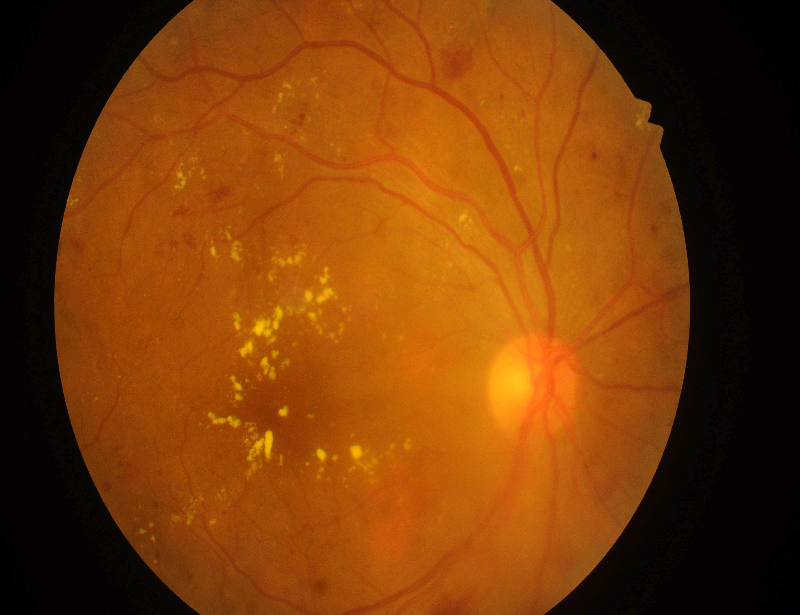

In [ ]:


fundus1 = cv2.imread('IDRiD_001.jpg')
fundus = cv2.resize(fundus1,(800,615))
cv2_imshow(fundus)

In [ ]:
fundus_mask = cv2.imread("fmask.png")
fundus_mask = cv2.resize(fundus_mask,(800,615))
#cv2_imshow(fundus_mask)

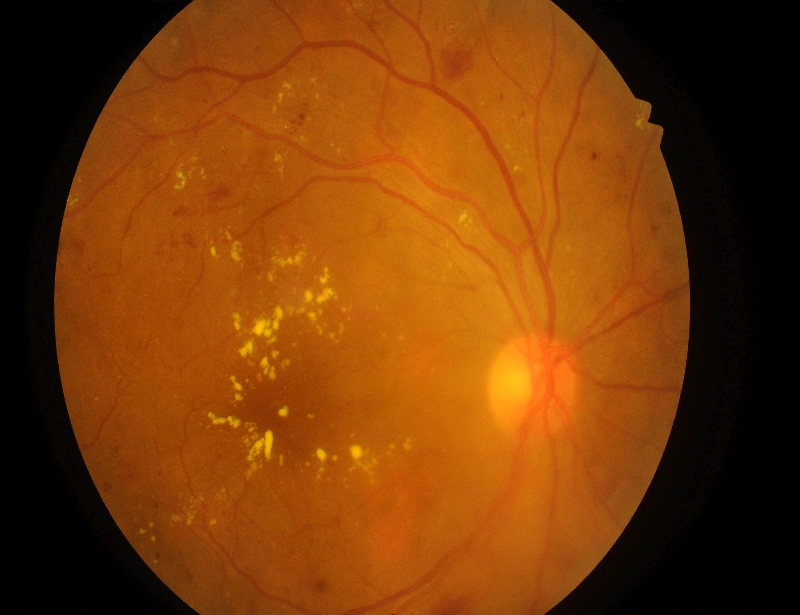

In [ ]:

f1 = cv2.bitwise_and(fundus[:,:,0],fundus_mask[:,:,0])
f2 = cv2.bitwise_and(fundus[:,:,1],fundus_mask[:,:,1])
f3 = cv2.bitwise_and(fundus[:,:,2],fundus_mask[:,:,2])
fundus_dash = cv2.merge((f1,f2,f3))
cv2_imshow(fundus_dash)

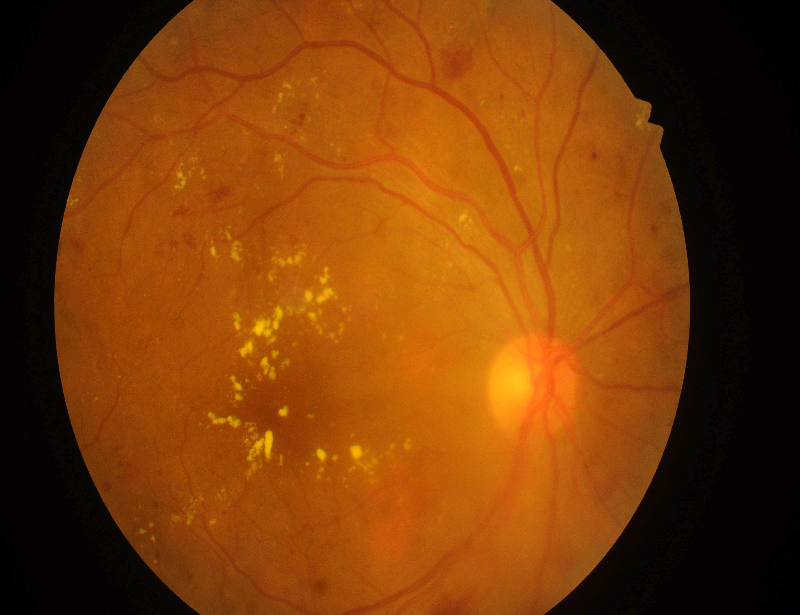

In [ ]:
cv2_imshow(fundus)

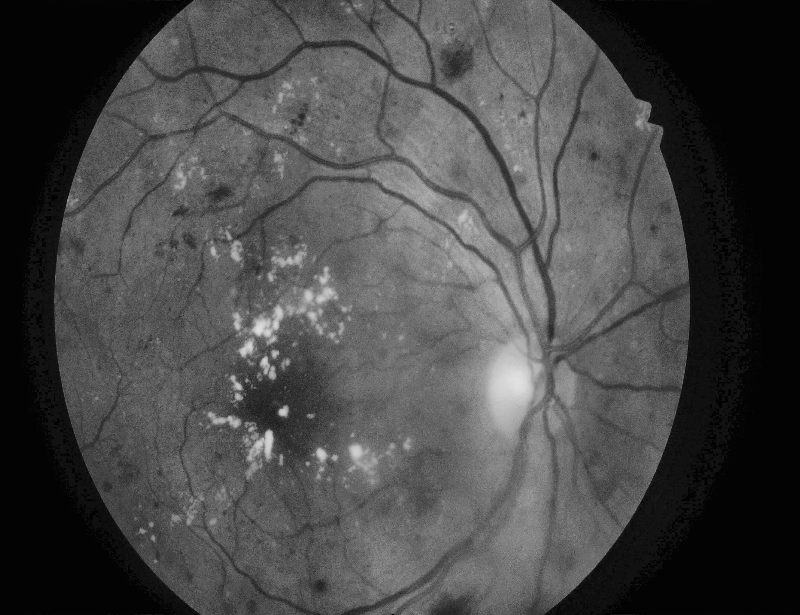

In [ ]:
b,g,r = cv2.split(fundus_dash)		
hsv_fundus = cv2.cvtColor(fundus_dash,cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv_fundus)		
gray_scale = cv2.cvtColor(fundus_dash,cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
contrast_enhanced_fundus = clahe.apply(gray_scale)		
contrast_enhanced_green_fundus = clahe.apply(g)

average_intensity = get_average_intensity(contrast_enhanced_green_fundus)/255
average_hue = get_average_hue(h)/255
average_saturation = get_average_saturation(s)/255
cv2_imshow(contrast_enhanced_green_fundus)

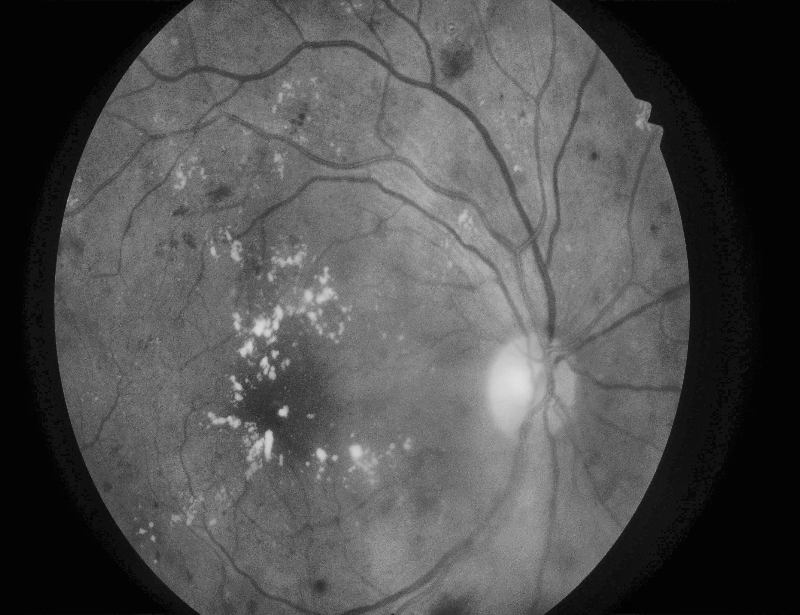

In [ ]:
cv2_imshow(contrast_enhanced_fundus)

In [ ]:
bv_image_dash = extract_bv(g)
bv_image = extract_bv(gray_scale)

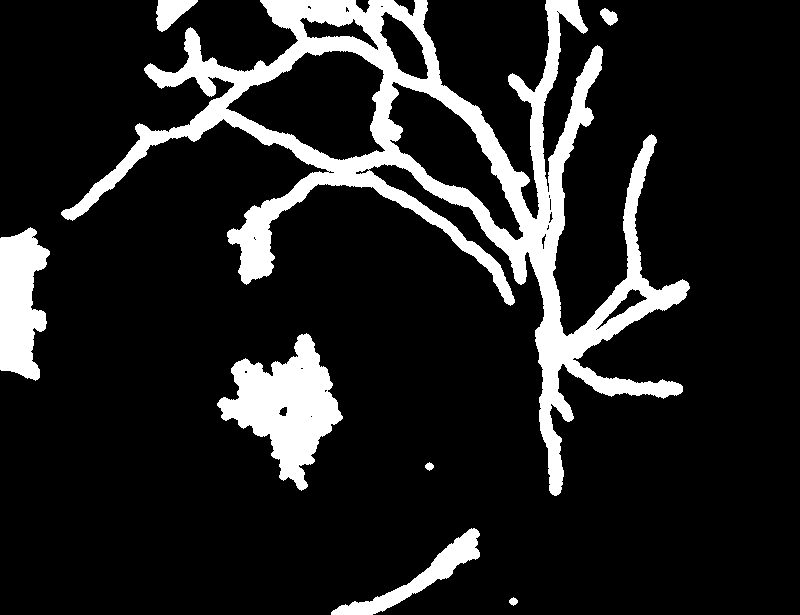

In [ ]:
bv_image_fovea = extract_bv_with_fovea(g)
cv2_imshow(bv_image_fovea)

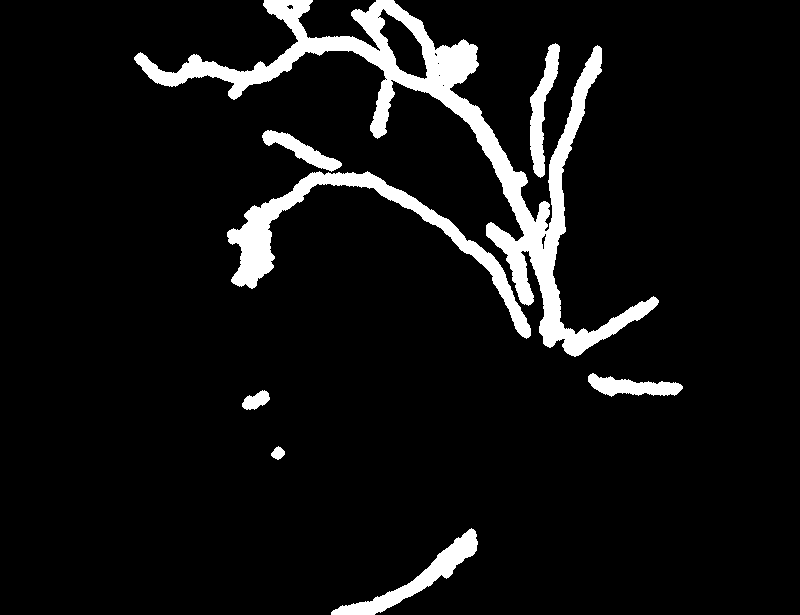

In [ ]:
cv2_imshow(bv_image)

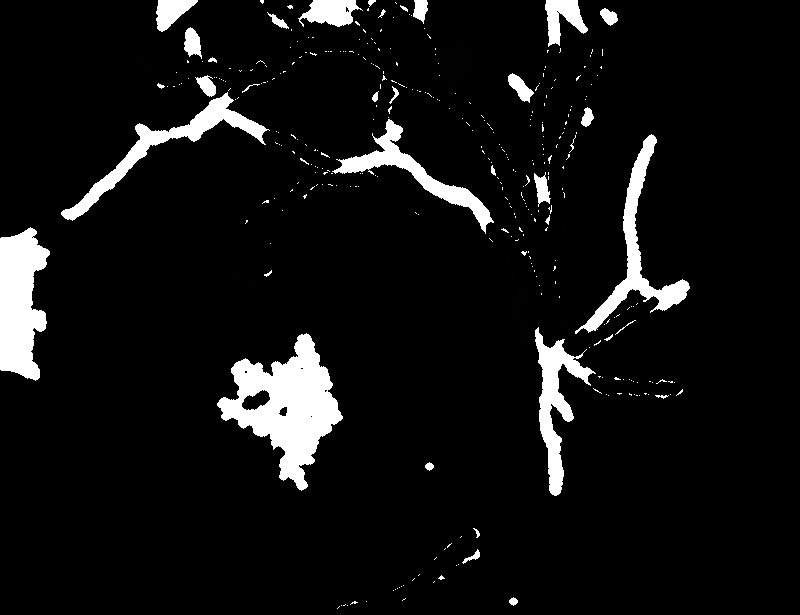

In [ ]:
fovea_image= bv_image_fovea - bv_image
cv2_imshow(fovea_image)

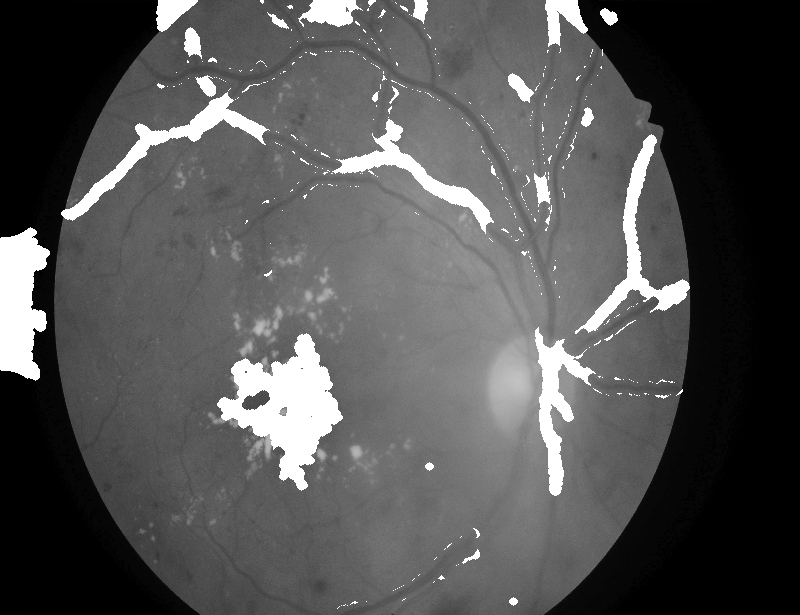

In [ ]:
fovea_over_real_img = np.bitwise_or(gray_scale,fovea_image)
cv2_imshow(fovea_over_real_img)

In [ ]:
var_fundus = standard_deviation_image(contrast_enhanced_fundus)
edge_feature_output = edge_pixel_image(gray_scale,bv_image_dash)	
newfin = cv2.dilate(edge_feature_output, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations=1)
edge_candidates = cv2.erode(newfin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)		
edge_candidates = np.uint8(edge_candidates)

<ipython-input-30-d5585a6ea5d6>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "standard_deviation_image" failed type inference due to: Unknown attribute 'createCLAHE' of type Module(<module 'cv2.cv2' from '/usr/local/lib/python3.6/dist-packages/cv2/cv2.cpython-36m-x86_64-linux-gnu.so'>)

File "<ipython-input-30-d5585a6ea5d6>", line 3:
def standard_deviation_image(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
 ^

During: typing of get attribute at <ipython-input-30-d5585a6ea5d6> (3)

File "<ipython-input-30-d5585a6ea5d6>", line 3:
def standard_deviation_image(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
 ^

  @jit
<ipython-input-30-d5585a6ea5d6>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "standard_deviation_image" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<

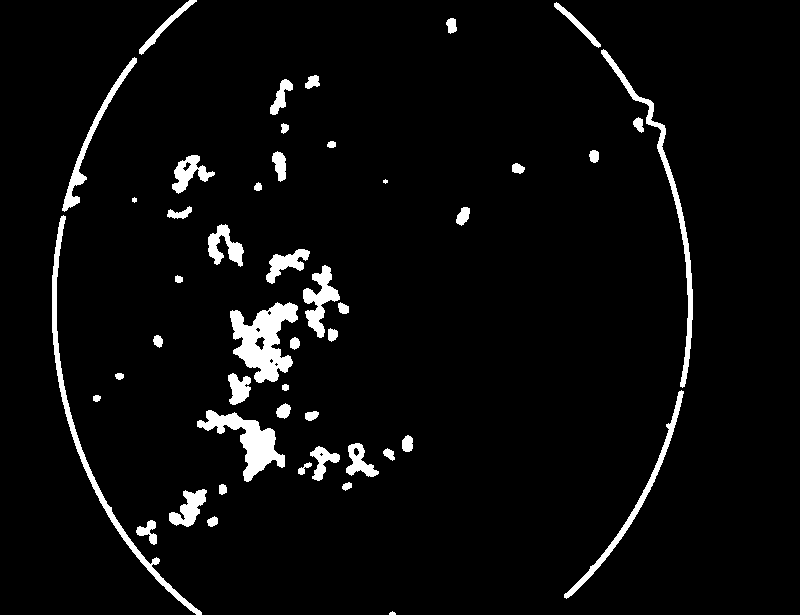

In [ ]:
cv2_imshow(edge_candidates)

In [ ]:

"""
coordinates_OD= identify_OD(bv_image)
deviation_matrix = deviation_from_mean(gray_scale)

feature1 = get_SD_data(var_fundus)/255
feature2 = get_HUE_data(h)/255
feature3 = get_saturation_data(s)/255
feature4 = get_INTENSITY_data(contrast_enhanced_fundus)/255
feature5 = get_RED_data(r)/255
feature6 = get_GREEN_data(g)/255
feature7 = get_DistanceFromOD_data(bv_image,coordinates_OD)/(var_fundus.shape[0]+var_fundus.shape[1])
feature8 = get_HUE_data(deviation_matrix)/255
"""


'\ncoordinates_OD= identify_OD(bv_image)\ndeviation_matrix = deviation_from_mean(gray_scale)\n\nfeature1 = get_SD_data(var_fundus)/255\nfeature2 = get_HUE_data(h)/255\nfeature3 = get_saturation_data(s)/255\nfeature4 = get_INTENSITY_data(contrast_enhanced_fundus)/255\nfeature5 = get_RED_data(r)/255\nfeature6 = get_GREEN_data(g)/255\nfeature7 = get_DistanceFromOD_data(bv_image,coordinates_OD)/(var_fundus.shape[0]+var_fundus.shape[1])\nfeature8 = get_HUE_data(deviation_matrix)/255\n'

In [ ]:
#Taking the hue and saturdation of the image 
#Z = np.hstack((feature2,feature3))
#Z = np.float32(Z)


In [ ]:
"""
from fcmeans import FCM
fcm = FCM(n_clusters=6,error=1e-8)
fcm.fit(Z)
fcm_centers = fcm.centers
fcm_labels = fcm.predict(Z)
fcm_centers = np.uint8(fcm_centers) 
"""

'\nfrom fcmeans import FCM\nfcm = FCM(n_clusters=6,error=1e-8)\nfcm.fit(Z)\nfcm_centers = fcm.centers\nfcm_labels = fcm.predict(Z)\nfcm_centers = np.uint8(fcm_centers) \n'

In [ ]:
#print(np.unique(fcm_labels, return_index=True, return_counts=True))

In [ ]:
"""
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.01)
ret,label,center=cv2.kmeans(Z,6,None,criteria,50,cv2.KMEANS_RANDOM_CENTERS)
u, indices, counts = np.unique(center, return_index=True, return_counts=True)
"""	

'\ncriteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.01)\nret,label,center=cv2.kmeans(Z,6,None,criteria,50,cv2.KMEANS_RANDOM_CENTERS)\nu, indices, counts = np.unique(center, return_index=True, return_counts=True)\n'

In [ ]:
#center_t = [(t[0]*255,t[1]*255) for t in center]

In [ ]:
#ex_color = (40,230)

In [ ]:
"""
distance = [(abs(t[0]- ex_color[0]),t) for t in center_t]								
index1 = distance.index((min(distance)))
if counts[distance.index((min(distance)))] > 0.2*gray_scale.shape[0]*gray_scale.shape[1]:
   index1 = -1		

distance2 = [(abs(t[0]- ex_color[0])+abs(t[1]-ex_color[1]),t) for t in center_t]		
index2 = -1		
if min(distance2)[0] <=25:
   index2 = distance2.index((min(distance2)))		
if counts[distance2.index((min(distance2)))] > 0.2*gray_scale.shape[0]*gray_scale.shape[1]:
	 index2 = -1
"""



'\ndistance = [(abs(t[0]- ex_color[0]),t) for t in center_t]\t\t\t\t\t\t\t\t\nindex1 = distance.index((min(distance)))\nif counts[distance.index((min(distance)))] > 0.2*gray_scale.shape[0]*gray_scale.shape[1]:\n   index1 = -1\t\t\n\ndistance2 = [(abs(t[0]- ex_color[0])+abs(t[1]-ex_color[1]),t) for t in center_t]\t\t\nindex2 = -1\t\t\nif min(distance2)[0] <=25:\n   index2 = distance2.index((min(distance2)))\t\t\nif counts[distance2.index((min(distance2)))] > 0.2*gray_scale.shape[0]*gray_scale.shape[1]:\n\t index2 = -1\n'

In [ ]:
"""
green = [0,255,0]
blue = [255,0,0]
red = [0,0,255]
white = [255,255,255]
black = [0,0,0]
pink = [220,30,210]
sky = [30,240,230]
yellow = [230,230,30]
color = [white,black,red,green,blue,pink]
color = np.array(color,np.uint8)
label = np.reshape(label, gray_scale.shape)
"""


'\ngreen = [0,255,0]\nblue = [255,0,0]\nred = [0,0,255]\nwhite = [255,255,255]\nblack = [0,0,0]\npink = [220,30,210]\nsky = [30,240,230]\nyellow = [230,230,30]\ncolor = [white,black,red,green,blue,pink]\ncolor = np.array(color,np.uint8)\nlabel = np.reshape(label, gray_scale.shape)\n'

In [ ]:
"""
test = np.copy(label)
#test = fcm_labels.copy()			
if index1 == -1:
		  test.copy().fill(0)
else:
      test[test==distance.index((min(distance)))] = 255
      test[test!=distance.index((min(distance)))] = -1
      test[test==-1] = 0
			
			

test2 = np.copy(label)
if index2 == -1:
			test2.fill(0)
else:
			test2[test2!=index2] = -1
			test2[test2==index2] = 255
			test2[test2==-1] = 0
	

y = color[label]
y = np.uint8(y)

res_from_clustering = np.bitwise_or(test2,test)
"""

'\ntest = np.copy(label)\n#test = fcm_labels.copy()\t\t\t\nif index1 == -1:\n\t\t  test.copy().fill(0)\nelse:\n      test[test==distance.index((min(distance)))] = 255\n      test[test!=distance.index((min(distance)))] = -1\n      test[test==-1] = 0\n\t\t\t\n\t\t\t\n\ntest2 = np.copy(label)\nif index2 == -1:\n\t\t\ttest2.fill(0)\nelse:\n\t\t\ttest2[test2!=index2] = -1\n\t\t\ttest2[test2==index2] = 255\n\t\t\ttest2[test2==-1] = 0\n\t\n\ny = color[label]\ny = np.uint8(y)\n\nres_from_clustering = np.bitwise_or(test2,test)\n'

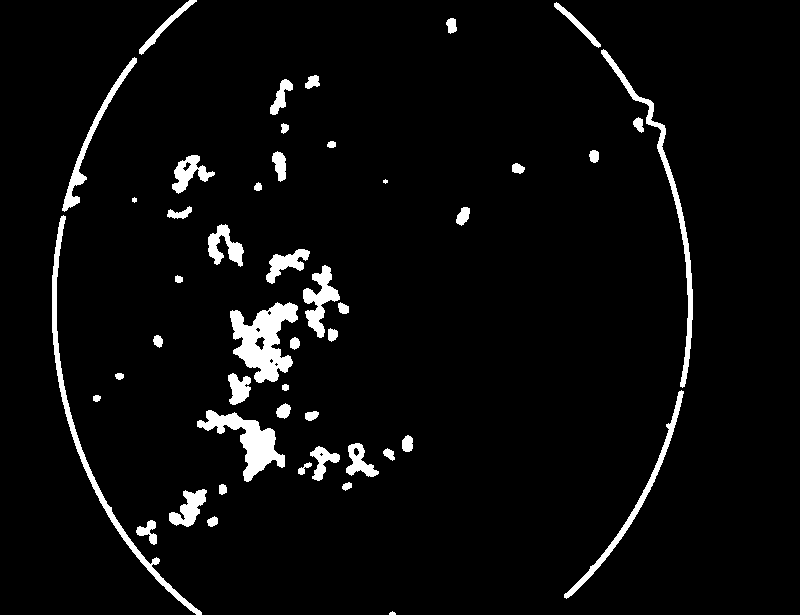

In [ ]:
cv2_imshow(edge_candidates)

In [ ]:

#final_candidates = np.bitwise_or(edge_candidates,res_from_clustering)	
final_candidates = edge_candidates

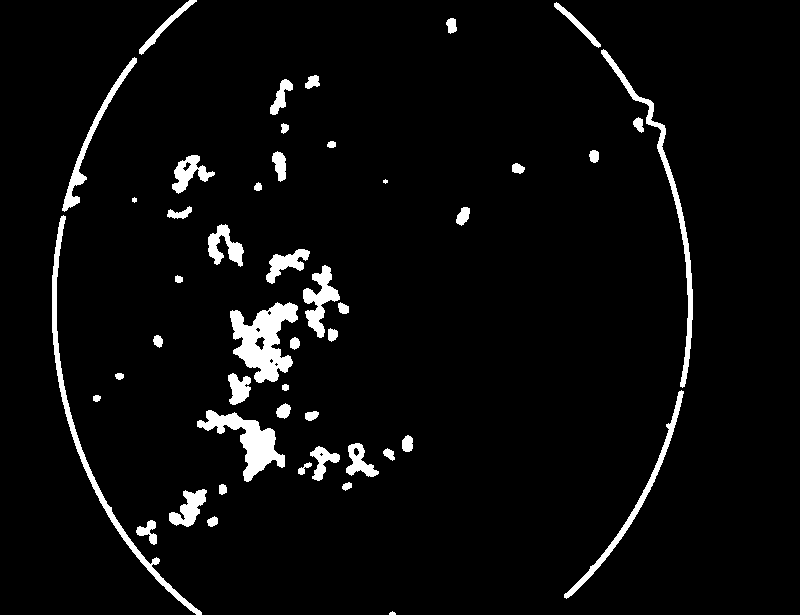

In [ ]:
cv2_imshow(final_candidates)

In [ ]:
green_scale_bv_removal= edge_pixel_image(final_candidates,bv_image_dash)
#green_scale_bv_removal= remove_bv_image(final_candidates,bv_image_dash)

In [ ]:
final_candidates = np.bitwise_or(final_candidates,green_scale_bv_removal)

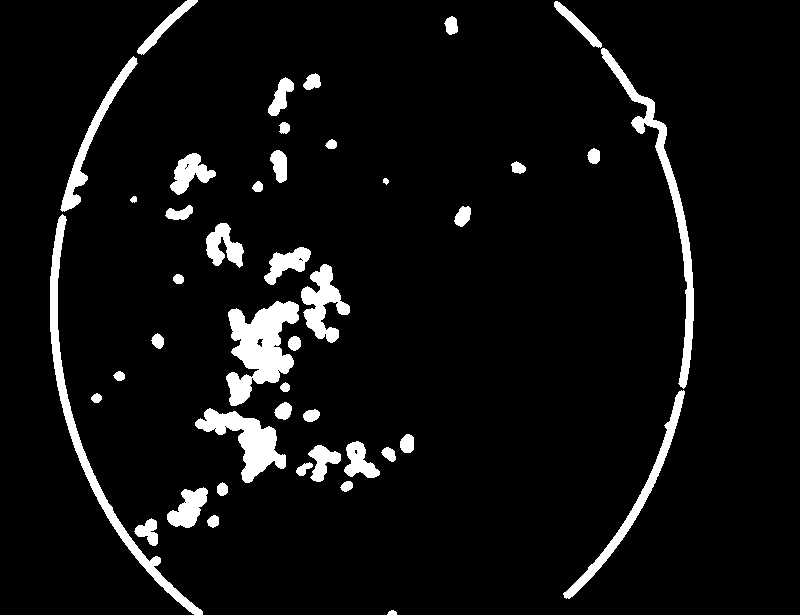

In [ ]:
cv2_imshow(final_candidates)

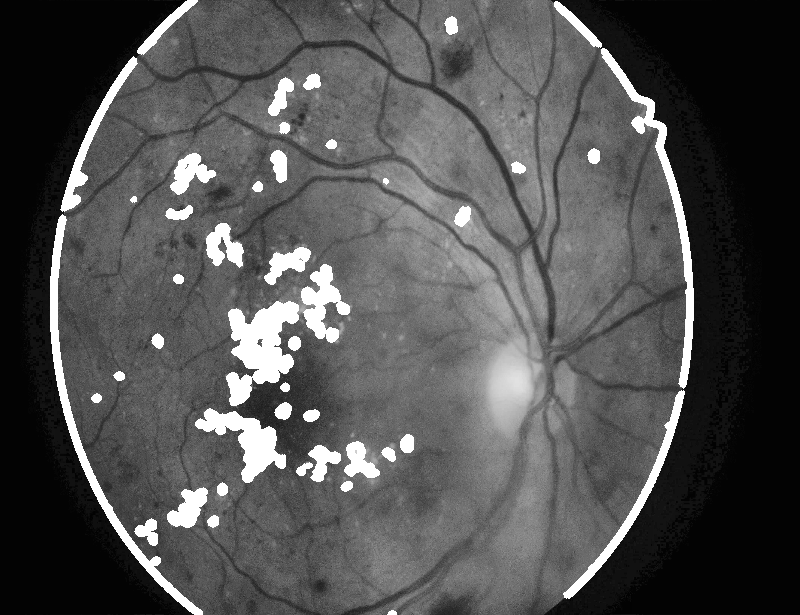

In [ ]:
x1= np.bitwise_or(contrast_enhanced_green_fundus,final_candidates)
cv2_imshow(x1)

In [ ]:
#cv2.circle(final_candidates,coordinates_OD, 70, (0,0,0), -10)
maskk = cv2.imread("MASK.bmp")
final_candidates = np.bitwise_and(final_candidates,maskk[:,:,0])

In [ ]:
final_candidates = final_candidates.astype('uint8')
final_candidates = cv2.dilate(final_candidates, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)		
		

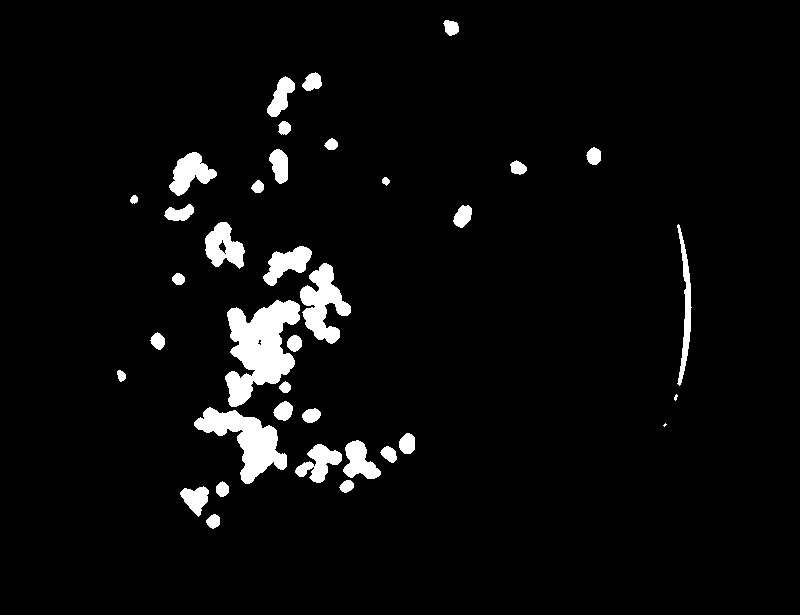

In [ ]:
cv2_imshow(final_candidates)

In [ ]:
final_candidates.shape

(615, 800)

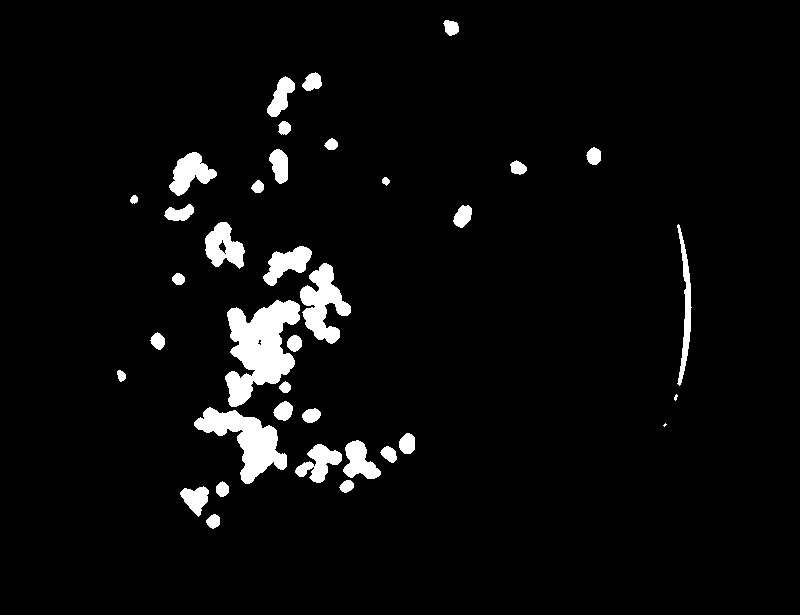

In [ ]:
cv2_imshow(final_candidates)

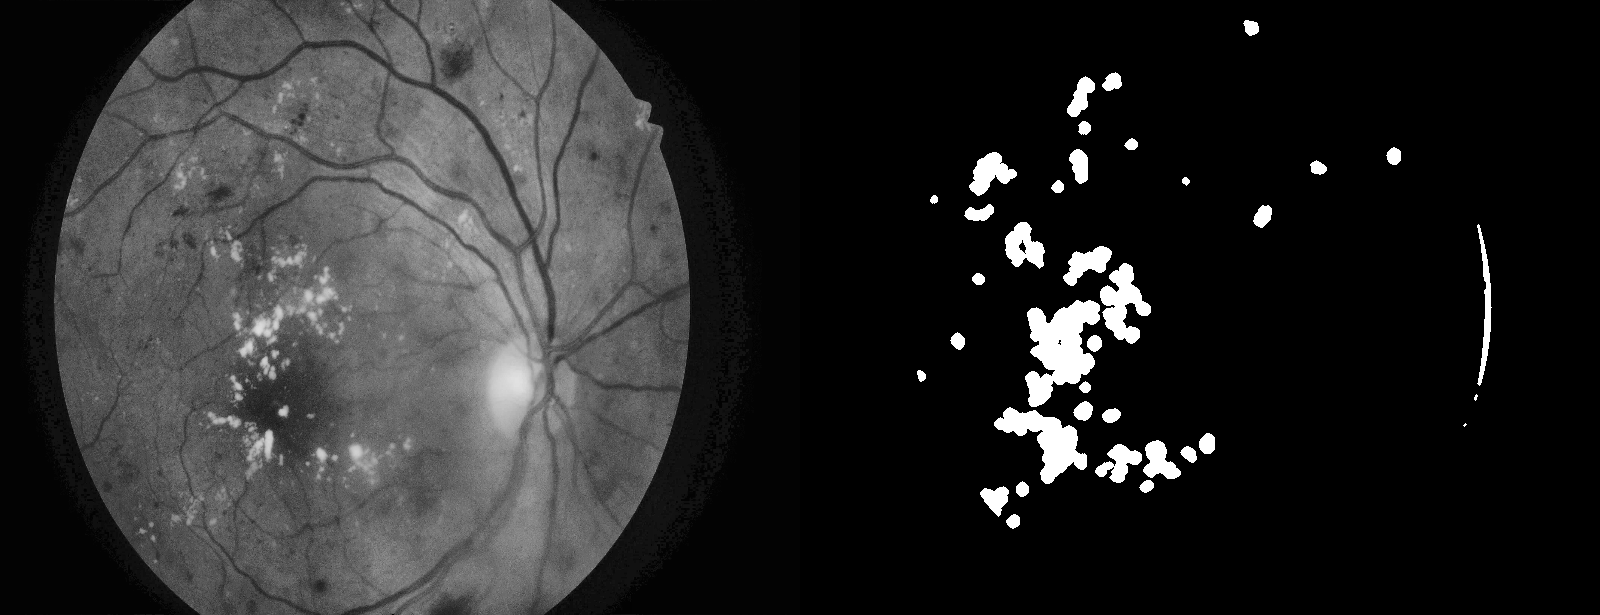

In [ ]:
vis = np.concatenate((contrast_enhanced_green_fundus, final_candidates),axis=1)
cv2_imshow(vis)

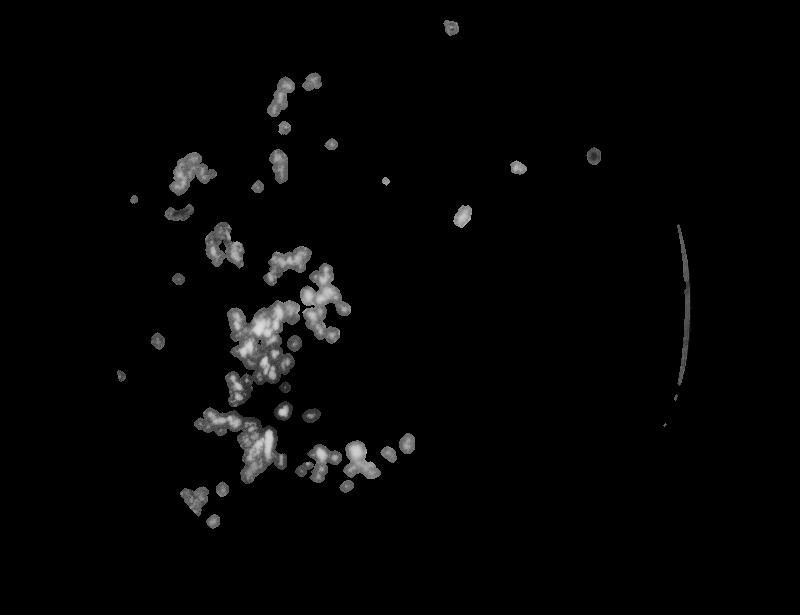

In [ ]:
x2= np.bitwise_and(contrast_enhanced_green_fundus,final_candidates)
cv2_imshow(x2)

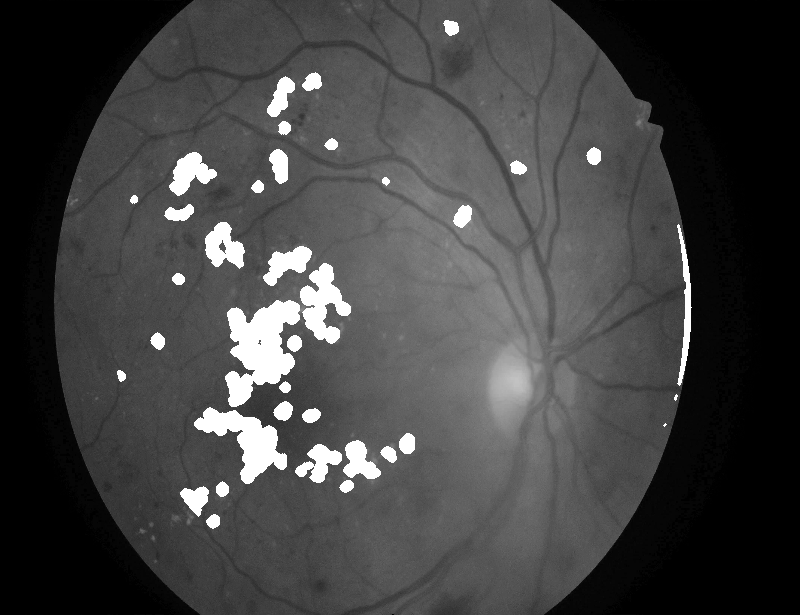

In [ ]:
x1= np.bitwise_or(g,final_candidates)
cv2_imshow(x1)

In [ ]:
identify_OD_bv_density(g)

(60, 308)

In [ ]:
import numpy as np
import argparse
import imutils
import cv2
from imutils import contours
from skimage import measure
from google.colab.patches import cv2_imshow

In [ ]:

blur = cv2.bilateralFilter(g,9,75,75)
median=cv2.medianBlur(blur,5)

In [ ]:
thresh = cv2.threshold(median, 155, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=4)

In [ ]:
labels = measure.label(thresh, neighbors=8, background=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  """Entry point for launching an IPython kernel.


In [ ]:
mask = np.zeros(thresh.shape, dtype="uint8")

In [ ]:
for label in np.unique(labels):
	# if this is the background label, ignore it
	if label == 0:
		continue

	# otherwise, construct the label mask and count the
	# number of pixels 
	labelMask = np.zeros(thresh.shape, dtype="uint8")
	labelMask[labels == label] = 255
	numPixels = cv2.countNonZero(labelMask)

	# if the number of pixels in the component is sufficiently
	# large, then add it to our mask of "large blobs"
	if numPixels >300:
		mask = cv2.add(mask, labelMask)

In [ ]:
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]

In [ ]:
for (i, c) in enumerate(cnts):
     ellipse = cv2.fitEllipse(c)
     
     
     cv2.ellipse(median,ellipse,(0,0,0),-10)
          
     #print(h)
     #print(w)
     #print(x)
     #print(y)
     break

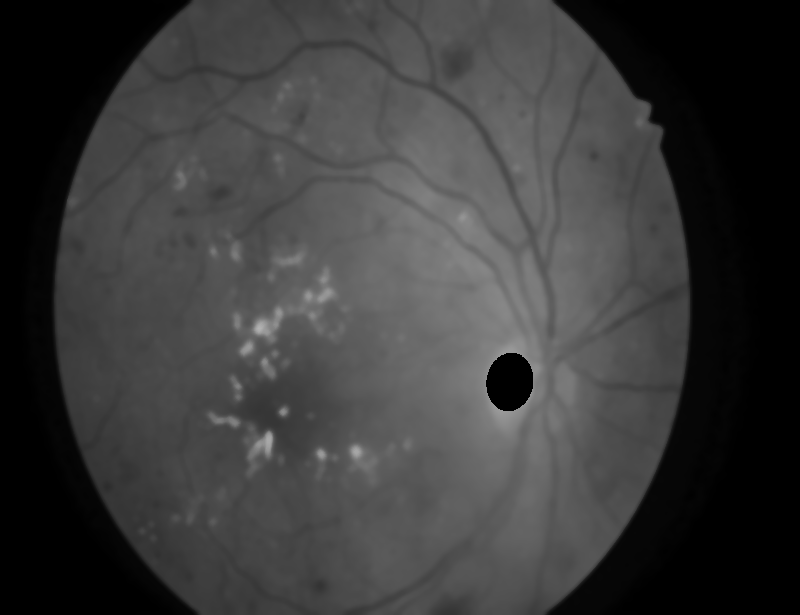

In [ ]:
cv2_imshow(median)

In [ ]:
x2= np.bitwise_or(median,final_candidates)

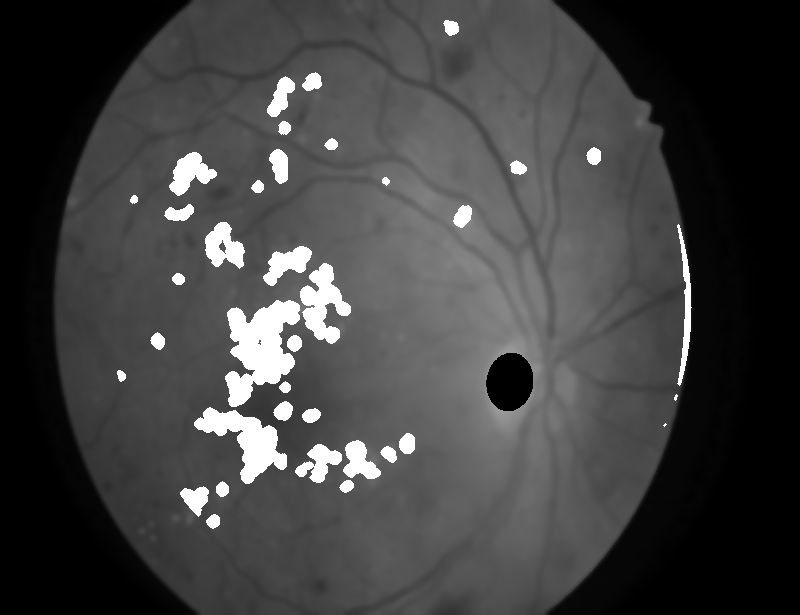

In [ ]:
cv2_imshow(x2)

In [ ]:
final_candidates = np.bitwise_and(x2,maskk[:,:,0])

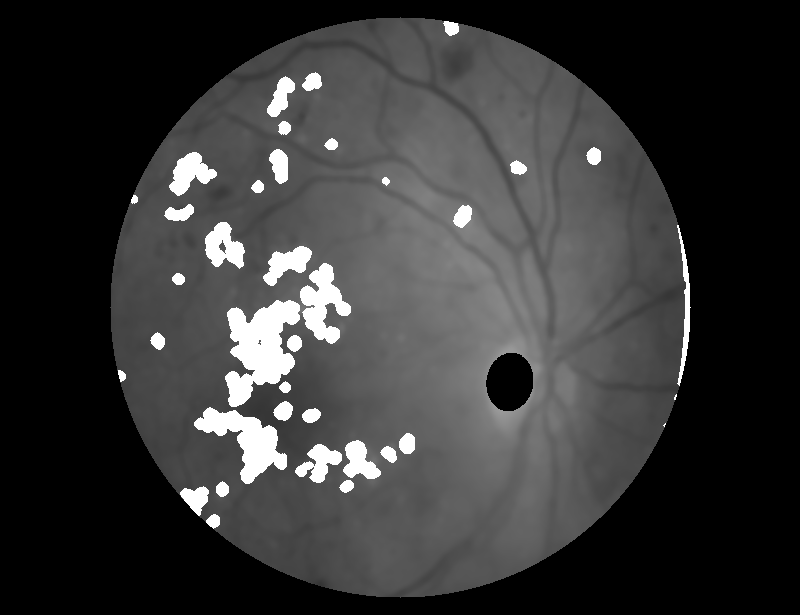

In [ ]:
cv2_imshow(final_candidates)

In [ ]:
cv2_imshow(f4)

NameError: ignored